# Active Learning
## Names :  Amine FERDJAOUI, Tanguy HERSERANT

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from scipy.stats import entropy
from sklearn.utils import Bunch
from sklearn.pipeline import Pipeline
from matplotlib.pyplot import figure
from matplotlib.pyplot import *
from numpy import linspace
from random import sample
import pandas as pd 
import numpy as np

## Import and Explore Data
In this project we used two different datasets. The first one is the following, which is a classic NLP dataset : $ng5$.<br>
The second dataset is downloaded online and will be presented after showing results on the $ng5$.

In [2]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [3]:
print("\n".join(train.data[0].split("\n")))


I'd be willing to make two wagers:
1) Snow doesn't win ROY.
2) Mattingly is out of baseball within five years.

I'm skeptical of the first, because I don't think Snow is that good a
player, and he is on a losing team.

I'm skeptical of the second because of his back.  Mattingly is 32 this
year, and how many players play until they are 40?  Not too many, and
most of them didn't have chronic back problems when they were 32.

Could be wrong on either or both, but I think that's the smart way to
bet...


In [4]:
print(train.target_names[train.target[0]])

rec.sport.baseball


### Define classifiers 
We used two classifiers to compare them : We first tested on simple Naive Bayes Classifier, and we used an SVM classifier after which we optimised by choosing the right parameters 

In [5]:
## Create a pipeline to make it simpler
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [6]:
## Create a pipeline to make it simpler
text_clf_svm = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier(loss='log', penalty='l2',
                           alpha=1e-5,random_state=42,
                           max_iter=5, tol=None)),
])

## Define Required Functions
These functions are used in the learner loop process. 

In [7]:
# Define the function that updates datasets (the seed and unlabeled tables)
def update(seed, unlabeled, ind):
    seed.data = seed.data + [unlabeled.data[i] for i in ind]
    seed.target = np.append(seed.target,unlabeled.target[ind])
    unlabeled.data = [unlabeled.data[i] for i in range(len(unlabeled.data)) if i not in ind]
    unlabeled.target = np.delete(unlabeled.target, ind)
    return seed, unlabeled

In [8]:
# Define the function that trains the model and stores accuracy 
def update_accuracy(seed, unlabeled, accuracy, classifier):
    global test
    # Train the clasifier
    classifier.fit(seed.data, seed.target)
    # predicted classes and corresponding probabilities
    predicted_proba = classifier.predict_proba(unlabeled.data)
    # check the real accuracy on test data
    predicted = classifier.predict(test.data)
    accuracy.append(np.mean(predicted == test.target))
    return accuracy, predicted_proba 

## Start the loop process (Function)
The Active Learner process is defined in a compact function that makes use of the two previous function in order to optimize the code

In [9]:
def active_learner(train, test, classifier, initial_size, n):

    length = len(train.data)
    seed_uncert = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_margin = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_entropy = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    seed_rand = Bunch(data=train.data[0:initial_size], target=train.target[0:initial_size])
    unlabeled_uncert = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_margin = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_entropy = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])
    unlabeled_rand = Bunch(data=train.data[initial_size:length-1], target=train.target[initial_size:length-1])

    accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = [], [], [], []
    
    # Start the loop
    while len(unlabeled_uncert.data) > 0:
        ## Least Confidence (aka. Uncertainty) Strategy
        accuracy_uncert, predicted_proba = update_accuracy(seed_uncert, unlabeled_uncert, accuracy_uncert, classifier)
        uncertainty = 1 - predicted_proba.max(axis=1)
        ## Margin Sampling
        accuracy_margin, predicted_proba = update_accuracy(seed_margin, unlabeled_margin, accuracy_margin, classifier)
        part = np.partition(-predicted_proba, 1, axis=1)
        margin = - part[:, 0] + part[:, 1]
        ## Entropy based
        accuracy_entropy, predicted_proba = update_accuracy(seed_entropy, unlabeled_entropy, accuracy_entropy, classifier)
        entr = entropy(predicted_proba.T)
        ## Random
        accuracy_rand, predicted_proba = update_accuracy(seed_rand, unlabeled_rand, accuracy_rand, classifier)

        if len(unlabeled_uncert.data) > n : 
            # index of top n uncertainty score
            ind_uncert = np.argpartition(uncertainty, -n)[-n:]
            # index of n min margin score
            ind_margin = np.argpartition(margin, n)[:n]
            # index of top n entropy score
            ind_entropy = np.argpartition(entr, -n)[-n:]
            # ind random
            ind_rand = sample([i for i in range(len(unlabeled_rand.data)-1)], n)

            seed_uncert, unlabeled_uncert = update(seed_uncert, unlabeled_uncert, ind_uncert)
            seed_margin, unlabeled_margin = update(seed_margin, unlabeled_margin, ind_margin)
            seed_entropy, unlabeled_entropy = update(seed_entropy, unlabeled_entropy, ind_entropy)
            seed_rand, unlabeled_rand = update(seed_rand, unlabeled_rand, ind_rand)
        else :
            # seed.data = seed.data + unlabeled.data
            # seed.target = np.append(seed.target, unlabeled.target)
            # text_clf.fit(seed.data, seed.target)
            unlabeled_uncert.data = unlabeled_margin = unlabeled_entropy = unlabeled_rand = []
    return accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand

## Test the Learner
Now that we are all set, we will test the Active Learner on our dataset ($ng5$) and get the accuracy with a validation set.<br>
The scores are stored in four different lists following the three strategies that an active learner can take : $Uncertainty$, $Margin$, $entropy$, and in addition to that we added a random method for comparison.<br>
The tests are the same for the svm classifier. The results are then compared.

In [10]:
accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = active_learner(train, test, text_clf, 200, 20)

In [11]:
accuracy_uncert_svm, accuracy_margin_svm, accuracy_entropy_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 200, 20)

Since the lenght of the test entries are around 4300, we chosed to take for initial learner size 500, in for each iteration we label 80 chosen entries.

## Plot Results 

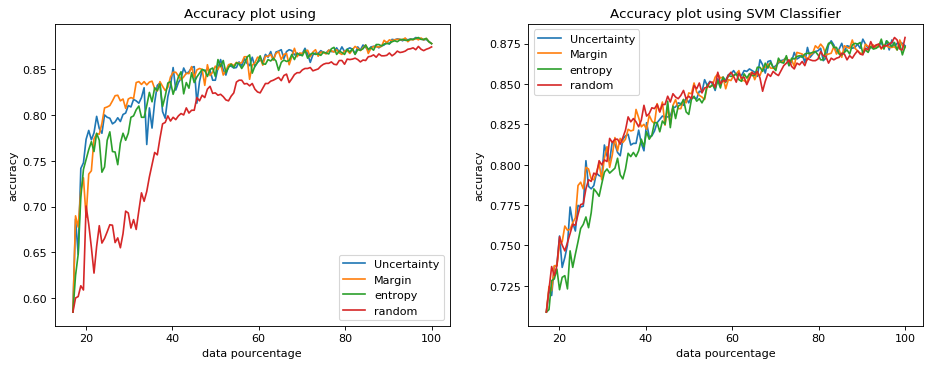

In [12]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, accuracy_uncert)
plot(x/len(train.data)*100, accuracy_margin)
plot(x/len(train.data)*100, accuracy_entropy)
plot(x/len(train.data)*100, accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using ')

## Plot accuracy plot using SVM Classifier

subplot(1, 2, 2)
plot(x/len(train.data)*100, accuracy_uncert_svm)
plot(x/len(train.data)*100, accuracy_margin_svm)
plot(x/len(train.data)*100, accuracy_entropy_svm)
plot(x/len(train.data)*100, accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier')

show()

# Import and Explore the second Dataset

The second dataset we used is very similar to $ng5$. It is available in kaggle for free : 
https://www.kaggle.com/himselfthedecker/facens-nlp-corpus-categorias-treino

In [20]:
data = pd.read_csv("corpus_categorias_treino.csv", sep=',', engine='python')
data = data[['words','category']]
data = data.sample(frac=1)
data.head()

,words,category
6738,( E ),government
4862,"We spend billions of dollars on liquor , and m...",religion
2798,A shine in her eyes suddenly became tears and ...,adventure
3833,Macneff stopped pacing to stare at Hal with hi...,science_fiction
2379,"In his dream he cried , `` Slow down , for Chr...",adventure


## Split Dataset
Since the dataset downloaded is not split so we have to do it.<br>
We chose 80% of the data for training and the rest for validation.<br>
We remarked that categories were ordered, so we had to shuffle the data a bit.

In [23]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
train = Bunch(data= train.words.values.tolist(), target=train.category.values)
test = data[~msk]
test = Bunch(data= test.words.values.tolist(), target=test.category.values)

## Launch the Model 
We apply the same process used previously.<br>
Since this time the dataset is larger (around 6000), we chose to start with 750 samples, and then we label 120 chosen samples for each iteration. 

In [24]:
accuracy_uncert, accuracy_margin, accuracy_entropy, accuracy_rand = active_learner(train, test, text_clf, 500, 40)
accuracy_uncert_svm, accuracy_margin_svm, accuracy_entropy_svm, accuracy_rand_svm = active_learner(train, test, text_clf_svm, 500, 40)

## Plot Results 

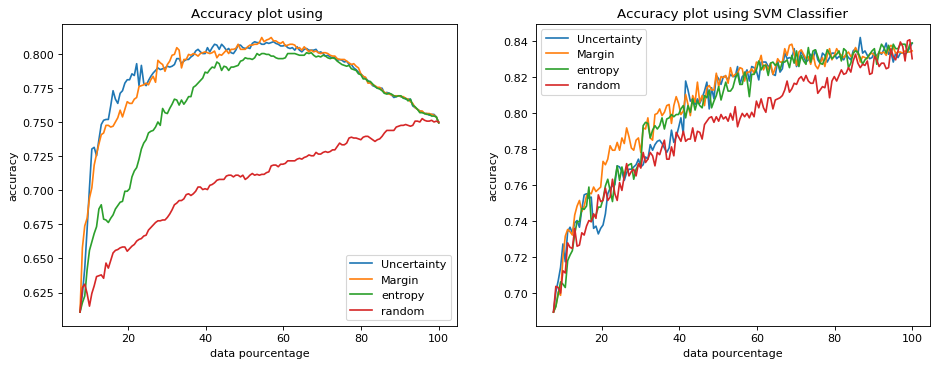

In [34]:
figure(num=None, figsize=(14, 5), dpi=80, facecolor='w', edgecolor='k')
x = linspace(500, len(train.data), len(accuracy_uncert))

subplot(1, 2, 1)
plot(x/len(train.data)*100, accuracy_uncert)
plot(x/len(train.data)*100, accuracy_margin)
plot(x/len(train.data)*100, accuracy_entropy)
plot(x/len(train.data)*100, accuracy_rand)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using ')

## Plot accuracy plot using SVM Classifier
x = linspace(500, len(train.data), len(accuracy_uncert_svm))

subplot(1, 2, 2)
plot(x/len(train.data)*100, accuracy_uncert_svm)
plot(x/len(train.data)*100, accuracy_margin_svm)
plot(x/len(train.data)*100, accuracy_entropy_svm)
plot(x/len(train.data)*100, accuracy_rand_svm)

xlabel('data pourcentage')
ylabel('accuracy')
legend(['Uncertainty','Margin','entropy', 'random'])

title('Accuracy plot using SVM Classifier')

show()